# Part 3

In this part, you will implement feature consistency analysis for model selection

In [ ]:
# Package installation - needed to run in google Collab. Comment this is you run the code locally 
!pip install git+https://github.com/engellab/neuralflow
!mkdir data
import urllib.request
urllib.request.urlretrieve('https://github.com/engellab/neuralflow/raw/master/tutorials/CCN2021/data/Ex3_datasample1.pkl', "data/Ex3_datasample1.pkl")
urllib.request.urlretrieve('https://github.com/engellab/neuralflow/raw/master/tutorials/CCN2021/data/Ex3_datasample2.pkl', "data/Ex3_datasample2.pkl")


In [1]:
import neuralflow
from neuralflow.utilities.FC_nonstationary import JS_divergence_tdp, FeatureComplexities, FeatureComplexity
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import pickle

We generated 400 trials of data from the ramping dynamics, split it into to equal data samples and optimized a model on each of the datasample for 10000 GD iterations. Let us initialize an EnergyModel class instance and load the optimization results.

In [2]:
EnergyModelParams = {'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111, 
               'peq_model':{'model': 'uniform', 'params': {}},
               'p0_model': {'model': 'single_well', 'params': {'miu': 200, 'xmin': -0.3}},
               'D0': 0.1,
               'boundary_mode':'absorbing',
               'num_neuron':1,
               'firing_model':[{'model': 'linear','params': {'r_slope': 50, 'r_bias': 60}}],
               'verbose':True
               }

# An instance of EnergyModel class that will be used for FC analysis. Note that here we set peq to uniform to pretend
# that we do not know the correct model
em_fitting = neuralflow.EnergyModel(**EnergyModelParams)

# Load the optimization results
with open ("data/Ex3_datasample1.pkl","rb") as fp:
    data1 = pickle.load(fp)
with open ("data/Ex3_datasample2.pkl","rb") as fp:
    data2 = pickle.load(fp)

# Also calculate the ground-truth model for visual comparison
peq_gt = neuralflow.peq_models.linear_pot(em_fitting.x_d_,em_fitting.w_d_,slope=-5)

Before proceding to feature consistency analysis, let us visualize the results of the first optimization.
Here we plot the potential function at selected iteration, and the negative loglikelihood as in the previous exercise. In addition to the training cost, we also plot validation cost (validation negative loglikelihood), which is calculated for each model produced by gradient descent on validation data (that was not used for training).

You can see that both validation and training costs display long horizontal plateaus (after initial fast descent). Due to the nuances in the data, the minimum of the validation cost can be achieved anywhere on this plateau. However, as you can see in the picture, if the minimum is achieved on a late iteration, the corresponding potential function will be overfitted. Thus, we need an alternative method for model selection.

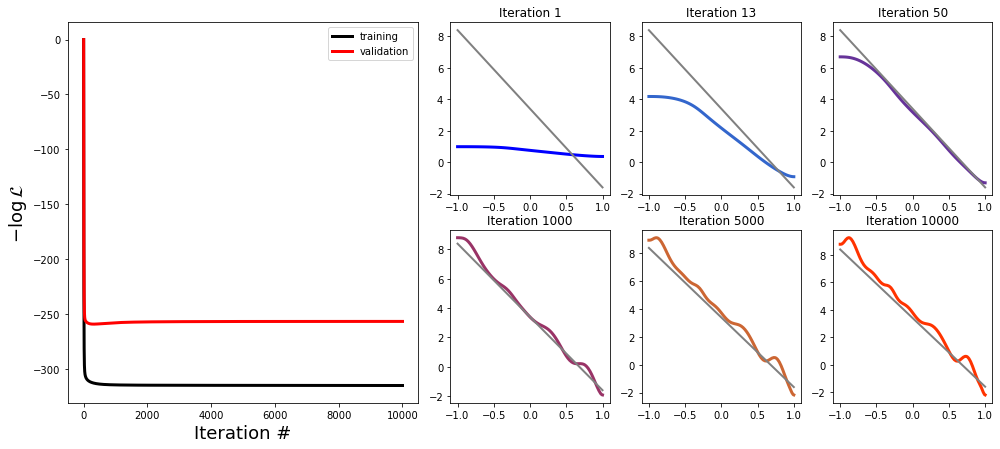

In [3]:
lls=data1['logliks']
lls_CV=data1['logliksCV']

#Shift training and validated loglikelihoods such that they both start from 0 for visualisation purposes
lls= (lls-lls[0])
lls_CV=(lls_CV-lls_CV[0])

fig=plt.figure(figsize=(20,7))
gridspec.GridSpec(2,6)

Iterations =[1,13,50,1000,5000,10000]
Iterations_indices = np.argmin(np.abs(np.subtract.outer(data1['iter_num'],Iterations)),axis=0)

colors=[[0.0, 0.0, 1.0],
        [0.2, 0.4, 0.8],
        [0.4, 0.2, 0.6],
        [0.6, 0.2, 0.4],
        [0.8, 0.4, 0.2],
        [1.0, 0.2, 0.0]]

# Plot negative loglikelihood vs. iteration number
plt.subplot2grid((2,6), (0,0), colspan=2, rowspan=2)

# Training negative loglikelihood
plt.plot(np.arange(1,lls.size+1),lls,color='black',linewidth=3,label='training')
# Validation negative loglikelihood
plt.plot(np.arange(1,lls_CV.size+1),lls_CV,color='red',linewidth=3, label='validation')
plt.xlabel('Iteration #', fontsize=18)
plt.ylabel(r'$-\log\mathcal{L}$', fontsize=18)
plt.legend()

#Plot potentials. Potential is calculated from peq by taking negative log: Phi = - log(peq). 
for i,Iter in enumerate(Iterations):
    plt.subplot2grid((2,6), (i//3,2+i%3))
    plt.plot(em_fitting.x_d_,-np.log(data1['peqs'][...,Iterations_indices[i]]),color=colors[i],linewidth=3)
    plt.plot(em_fitting.x_d_,-np.log(peq_gt),color='grey',linewidth=2)
    plt.title(f'Iteration {Iter}') 

Let us implement feature consistency analysis for model selection.

In [5]:
#Only consider the models at selected iterations (arranged on a logspace between 0 and 10,000).
number_of_models = 100
iterations_selected=np.unique(np.concatenate((np.array([0]),np.logspace(0,4,number_of_models))).astype(int))

#Find the indices of the selected iterations in the data1/data2 arrays
iteration_indices = np.argmin(np.abs(np.subtract.outer(data1['iter_num'],iterations_selected)),axis=0)

# For each model calculate feature complexity, and the eigenvalues and eigenvectors of the operator H0
# using our utility function
FCs_array1, lQ_array1, Qx_array1=FeatureComplexities(data1,em_fitting,iteration_indices)
FCs_array2, lQ_array2, Qx_array2=FeatureComplexities(data2,em_fitting,iteration_indices)

Now calculate JS divergence at each level of feature complexity

In [21]:
# This parameter will determine how many models from sequence 2 are compared with a model from sequence 1 for each 
# level of feature complexity
FC_stride = 5

# Preallocate JS divergence array 
JS = np.zeros(FCs_array1.size)

# For the second sequence, mid_inds2 will contain index of the model for each feature complexity in data2.
min_inds2 = np.zeros_like(JS)

for i in range(FCs_array1.size):
    # We only consider 1 model from the sequence of models optimized on data sample 1.
    FC1_ind = i
    
    # Find the index of a model in the second sequence FCs_array2 that have the closest feature complexity  
    # to the model from the first sequence 
    ind_seq_2 = np.argmin(np.abs(FCs_array1[FC1_ind]-FCs_array2))
    
    # Select the indices of 2*FC_stride-1 models from the second sequence of models around the index ind_seq_2
    FC2_ind = np.array(np.arange(max(0,ind_seq_2-FC_stride),min(FCs_array2.size-1,ind_seq_2+1+FC_stride)))    
    
    #Compute JSD for each pair of models selected from the sequences 1 and 2.
    JS_cur = np.zeros(FC2_ind.size)
    
    for i2, ind2 in enumerate(FC2_ind):
        peq_ind1=iteration_indices[FC1_ind]
        peq_ind2=iteration_indices[ind2]
        JS_cur[i2]=JS_divergence_tdp(data1['peqs'][...,peq_ind1],em_fitting.D_,em_fitting.p0_,
                                        data2['peqs'][...,peq_ind2],em_fitting.D_,em_fitting.p0_,
                                        em_fitting.w_d_, lQ_array1[FC1_ind,:], Qx_array1[FC1_ind,:], 
                                        lQ_array2[ind2,:], Qx_array2[ind2,:],1,10)
    
    # Find the index of model2 in data2 
    m2 = np.argmin(JS_cur)
    min_inds2[i] = iteration_indices[FC2_ind[m2]]
    
    # JS[i] should be equal to the minimal value of JS_cur
    
    ######INSERT YOUR CODE HERE############
    JS[i] = None
    #######################################
    
# For the first sequence of model, we only consider a single model for each feature complexity
min_inds1 = iteration_indices[np.arange(FCs_array1.size)]
    

Now threshold FC divergence and plot the results

Text(0, 0.5, 'Potential, $\\Phi(x)$')

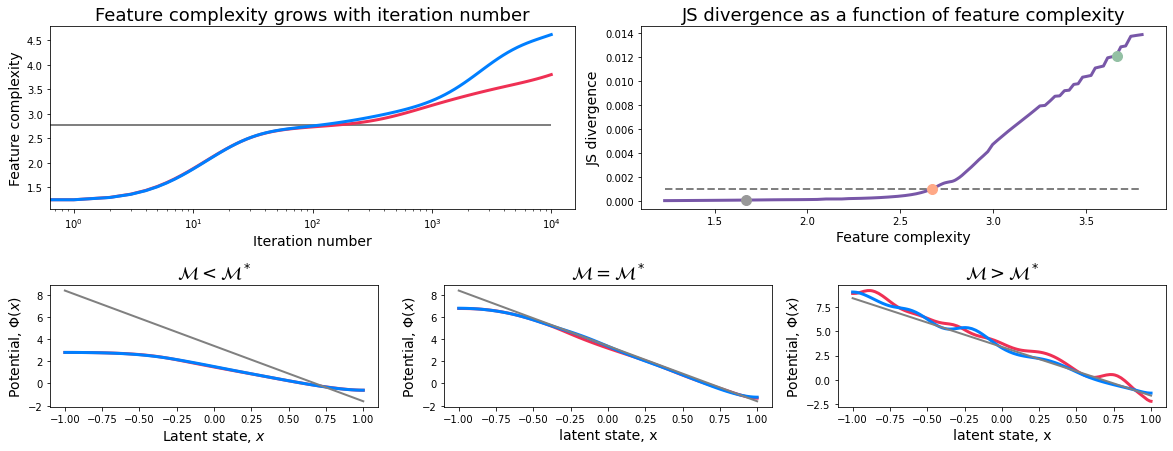

In [22]:
#JS divergence threshold
JS_thres=0.001
#Index of the optimal model
optimal_ind=np.where(JS>JS_thres)[0][0]-1
#Optimal FC
FC_opt = FCs_array1[optimal_ind]
#For illustration purposes, choose early and late FCs.
FC_late=FC_opt + 1 
late_ind = np.where(FCs_array1>FC_late)[0][0]
FC_early=FC_opt - 1
early_ind = np.where(FCs_array1>FC_early)[0][0]

#Create a ground-truth model, calculate its Feature Complexity.
EnergyModelParams = {'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111, 
               'peq_model':{"model": "linear_pot", "params": {"slope": -5}},
               'p0_model': {'model': 'single_well', 'params': {'miu': 200, 'xmin': -0.3}},
               'D0': 0.1,
               'boundary_mode':'absorbing',
               'num_neuron':1,
               'firing_model':[{'model': 'linear','params': {'r_slope': 50, 'r_bias': 60}}],
               'verbose':True
               }
em_gt = neuralflow.EnergyModel(**EnergyModelParams)
FC_gt = FeatureComplexity(em_gt)

#Visualization
fig=plt.figure(figsize=(20,7));
gs=gridspec.GridSpec(2,6,height_ratios=[3,2],hspace=0.5, wspace=0.5);
line_colors = [[239/255, 48/255, 84/255], [0, 127/255, 1], [0.5, 0.5, 0.5]]
dot_colors = [[0.6,0.6,0.6], [1, 169/255, 135/255],  [147/255, 192/255, 164/255]]

ax = plt.subplot(gs[0,:3])
ax.set_title('Feature complexity grows with iteration number',fontsize=18)
ax.plot(data1['iter_num'][iteration_indices],FCs_array1,color=line_colors[0],linewidth=3,label='Data sample 1')
ax.plot(data2['iter_num'][iteration_indices],FCs_array2,color=line_colors[1],linewidth=3,label='Data sample 2')
ax.hlines(FC_gt,data1['iter_num'][iteration_indices][0],data1['iter_num'][iteration_indices][-1],color=line_colors[2],linewidth=2,label='Ground truth')
plt.xscale('log')
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel('Feature complexity', fontsize=14)

ax=plt.subplot(gs[0,3:])
ax.set_title('JS divergence as a function of feature complexity',fontsize=18)
ax.plot(FCs_array1,JS, color = [0.47, 0.34, 0.66],linewidth=3)
ax.plot(FC_early,JS[np.argmin(np.abs(FCs_array1-FC_early))],'.',markersize=20,color=dot_colors[0])
ax.plot(FC_opt,JS[np.argmin(np.abs(FCs_array1-FC_opt))],'.',markersize=20,color=dot_colors[1])
ax.plot(FC_late,JS[np.argmin(np.abs(FCs_array1-FC_late))],'.',markersize=20,color=dot_colors[2])
ax.hlines(JS_thres,FCs_array1[0],FCs_array1[-1],linestyles='dashed',color=line_colors[2],linewidth=2,label='Ground truth')
plt.xlabel('Feature complexity',fontsize=14)
plt.ylabel('JS divergence', fontsize=14)


ax=plt.subplot(gs[1,:2])
ax.set_title(r'$\mathcal{M}<\mathcal{M}^*$', fontsize=18)
ax.plot(em_gt.x_d_,-np.log(data1['peqs'][...,int(min_inds1[early_ind])]),color=line_colors[0],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(data2['peqs'][...,int(min_inds2[early_ind])]),color=line_colors[1],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(em_gt.peq_),color=[0.5, 0.5, 0.5],linewidth=2)
plt.xlabel(r'Latent state, $x$', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

ax=plt.subplot(gs[1,2:4])
ax.set_title(r'$\mathcal{M}=\mathcal{M}^*$', fontsize=18)
ax.plot(em_gt.x_d_,-np.log(data1['peqs'][...,int(min_inds1[optimal_ind])]),color=line_colors[0],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(data2['peqs'][...,int(min_inds2[optimal_ind])]),color=line_colors[1],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(em_gt.peq_),color=[0.5, 0.5, 0.5],linewidth=2)
plt.xlabel('latent state, x', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

ax=plt.subplot(gs[1,4:])
ax.set_title(r'$\mathcal{M}>\mathcal{M}^*$', fontsize=18)
ax.plot(em_gt.x_d_,-np.log(data1['peqs'][...,int(min_inds1[late_ind])]),color=line_colors[0],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(data2['peqs'][...,int(min_inds2[late_ind])]),color=line_colors[1],linewidth=3)
ax.plot(em_gt.x_d_,-np.log(em_gt.peq_),color=[0.5, 0.5, 0.5],linewidth=2)
plt.xlabel('latent state, x', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

